# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, we will be finding lane lines on the road by using different image processing techniques.
We will make use of Canny Edge detection,Hough Transform ,Linear regression and extrapolation techniques to detect the lane lines on the image.


## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


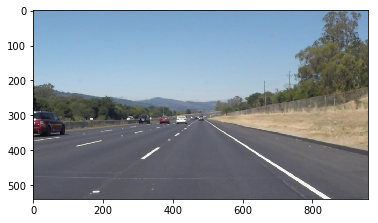

In [2]:
#reading in an image
image = mpimg.imread('laneDetected_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline



`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image



## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Canny Edge Detector
low_threshold = 50
high_threshold = 150

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

# Gaussian smoothing
kernel_size = 3

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

# Region-of-interest trapzd_corners
# We want a trapezoid shape, with bottom edge at the bottom of the image
def region_of_interest(img, trapzd_corners):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `trapzd_corners`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "trapzd_corners" with the fill color    
    cv2.fillPoly(mask, trapzd_corners, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image



def draw_lines(img, lines, color=[0, 255, 0], thickness=10):
    
    trapz_start = 340
    trapz_end = 550
    left_x1s = []
    left_y1s = []
    left_x2s = []
    left_y2s = []
    right_x1s = []
    right_y1s = []
    right_x2s = []
    right_y2s = []
    for line in lines:
        
        for x1,y1,x2,y2 in line:

            
            slope = Calculate_slope(x1,y1,x2,y2)
            if slope < 0:
                
                if slope > -.5 or slope < -.8:
                    continue        
                left_x1s.append(x1)
                left_y1s.append(y1)
                left_x2s.append(x2)
                left_y2s.append(y2)
            else:
                # Ignore obviously invalid lines
                if slope < .5 or slope > .8:
                    continue        
                right_x1s.append(x1)
                right_y1s.append(y1)
                right_x2s.append(x2)
                right_y2s.append(y2)
                
    try:
        avg_right_x1 = int(np.mean(right_x1s))
        avg_right_y1 = int(np.mean(right_y1s))
        avg_right_x2 = int(np.mean(right_x2s))
        avg_right_y2 = int(np.mean(right_y2s))
        right_slope = Calculate_slope(avg_right_x1,avg_right_y1,avg_right_x2,avg_right_y2)

        right_y1 = trapz_start
        right_x1 = int(avg_right_x1 + (right_y1 - avg_right_y1) / right_slope)
        right_y2 = trapz_end
        right_x2 = int(avg_right_x1 + (right_y2 - avg_right_y1) / right_slope)
        cv2.line(img, (right_x1, right_y1), (right_x2, right_y2), color, thickness)
    except ValueError:
        # to remove NaN Error
        pass

    try:
        avg_left_x1 = int(np.mean(left_x1s))
        avg_left_y1 = int(np.mean(left_y1s))
        avg_left_x2 = int(np.mean(left_x2s))
        avg_left_y2 = int(np.mean(left_y2s))
        left_slope = Calculate_slope(avg_left_x1,avg_left_y1,avg_left_x2,avg_left_y2)

        left_y1 = trapz_start
        left_x1 = int(avg_left_x1 + (left_y1 - avg_left_y1) / left_slope)
        left_y2 = trapz_end
        left_x2 = int(avg_left_x1 + (left_y2 - avg_left_y1) / left_slope)
        cv2.line(img, (left_x1, left_y1), (left_x2, left_y2), color, thickness)        
    except ValueError:
        # to remove NaN Error
        pass
    
def Calculate_slope(x1,y1,x2,y2):
    return ((y2-y1)/(x2-x1))
    
  
    #Hough Transform parameters
rho = 2 
theta = np.pi/180 
threshold = 15     
min_line_length = 10 
max_line_gap = 20    

def hough_lines(img, rho, theta, threshold, min_line_length, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_length, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)  # 3-channel RGB image
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    
    return cv2.addWeighted(initial_img, α, img, β, λ)





## Test Images



In [4]:
import os
os.listdir("laneDetected_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

In [5]:
def draw_lanedetect_image(rawimage):
    """ Given an image Numpy array, return the annotated image as a Numpy array """
    
    #merged = Extract_white_yellow(rawimage)
    
    #blacking out other pixels other than white and yellow
    # Extracting white pixels out of image 
    white_threshold = 210
    lower_white = np.array([white_threshold,white_threshold,white_threshold])
    upper_white = np.array([255, 255, 255])
    white_mask = cv2.inRange(rawimage, lower_white, upper_white)
    white_image = cv2.bitwise_and(rawimage, rawimage, mask=white_mask)

    # Extracting yellow pixels out of the image 
    hsv_image = cv2.cvtColor(rawimage, cv2.COLOR_BGR2HSV)
    lower_yellow = np.array([90,100,100])
    upper_yellow = np.array([110,255,255])
    yellow_mask = cv2.inRange(hsv_image, lower_yellow, upper_yellow)
    yellow_image = cv2.bitwise_and(rawimage, rawimage, mask=yellow_mask)

    # Merging both white and yellow images
    merged = cv2.addWeighted(white_image, 1., yellow_image, 1., 0.)
    
    
    # Read in and grayscale the image
    gray_image = grayscale(merged)

    # Gaussian smoothing applied to graysale image
    gaussian_image = gaussian_blur(gray_image, kernel_size)

    # Canny Edge Detection on gaussian_image
    Canny_image = canny(gaussian_image, low_threshold, high_threshold)

    # Create masked edges using trapezoid-shaped region-of-interest
    
    trapzd_corners = np.array([[[350,300],[450,300],[900,530],[100,530]]],dtype=np.int32)
    masked_edges = region_of_interest(Canny_image, trapzd_corners)

    # Run Hough on edge detected image
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    
    # Draw lane lines on the original image
    rawimage = rawimage.astype('uint8')
    laneDetect_image = weighted_img(line_image, rawimage)
    
    return laneDetect_image

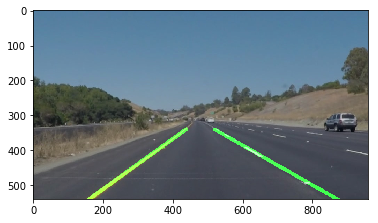

In [6]:
# Drawing exaple image
laneDetect_image = draw_lanedetect_image(mpimg.imread('laneDetected_images/solidYellowCurve.jpg'))
plt.imshow(laneDetect_image)

In [7]:
# Drawing all test_images/*.jpg

laneDetected_images = os.listdir('laneDetected_images/')

for image in laneDetected_images:
    laneDetect_image = draw_lanedetect_image(mpimg.imread((os.path.join('laneDetected_images', image))))
    fname = image.split('.')[0] + '_lanedetect.jpg'  # add '_annotated' suffix to annotated image jpg file
    plt.imsave(os.path.join('laneDetected_images', fname), laneDetect_image)

In [8]:
gray_images = os.listdir('grayscale_images/')

for image in gray_images:
    grayscale_image = grayscale(mpimg.imread((os.path.join('grayscale_images', image))))
    fname = image.split('.')[0] + '_gray.jpg'  # add '_gray' suffix to annotated image jpg file
    plt.imsave(os.path.join('grayscale_images', fname), grayscale_image)

In [9]:
canny_images = os.listdir('canny_images/')

for image in canny_images:
    gray_image = grayscale(mpimg.imread((os.path.join('canny_images', image))))
    canny_image = canny(gray_image,low_threshold,high_threshold)
    fname = image.split('.')[0] + '_canned.jpg'  # add '_canned' suffix to annotated image jpg file
    plt.imsave(os.path.join('canny_images', fname), canny_image)

In [10]:
Houghed_images = os.listdir('Houghed_images/')

for image in Houghed_images:
    gray_image = grayscale(mpimg.imread((os.path.join('Houghed_images', image))))
    canny_image = canny(gray_image,low_threshold,high_threshold)
    Houghed_image = hough_lines(canny_image, rho, theta, threshold, min_line_length, max_line_gap)
    fname = image.split('.')[0] + '_houghed.jpg'  # add '_houghed' suffix to annotated image jpg file
    plt.imsave(os.path.join('Houghed_images', fname), Houghed_image)

H:\Anaconda3\envs\py35\lib\site-packages\ipykernel\__main__.py:121: RuntimeWarning: divide by zero encountered in int_scalars


## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [11]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

## Test on Videos



In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [13]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result = draw_lanedetect_image(image)

    return result

Let's try the one with the solid white lane on the right first ...

In [14]:
white_output = 'Lane_White_Right.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video Lane_White_Right.mp4
[MoviePy] Writing video Lane_White_Right.mp4


100%|███████████████████████████████████████▊| 221/222 [00:09<00:00, 23.83it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Lane_White_Right.mp4 

Wall time: 11.1 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'Lane_Yellow_left.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video Lane_Yellow_left.mp4
[MoviePy] Writing video Lane_Yellow_left.mp4


 93%|█████████████████████████████████████▏  | 635/682 [00:43<00:03, 14.40it/s]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'Curved_Road_Lane.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))